# Working with Large Datasets

Sometimes in climate, we have very large datasets that don't all fit in memory or even if they do will take a long time to calculate. We can use `dask` to handle the data in `chunks` that will fit in memory and/or be computed in parallel. 

### Dask Arrays

[Dask](https://dask.org/)

[Dask and Xarray](http://xarray.pydata.org/en/stable/dask.html)

A `dask` array looks and feels a lot like a `numpy` array. However, a `dask` array doesn’t directly hold any data. Instead, it symbolically represents the computations needed to generate the data. Nothing is actually computed until the actual numerical values are needed. This mode of operation is called “lazy”; it allows one to build up complex, large calculations symbolically before turning them over the scheduler for execution.

From 
https://earth-env-data-science.github.io/lectures/dask/dask_arrays.html

In [1]:
#conda install graphviz python-graphviz # Will use this later to visualize how dask manages large data calculations

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

### Let's make a big array...

In [3]:
shape=(1000,4000)
ones_np=np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [4]:
print(ones_np.nbytes/1e6,"MB")

32.0 MB


In [5]:
import dask.array as da
ones=da.ones(shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

In [6]:
chunk_shape=(1000,1000)
ones=da.ones(shape,chunks=chunk_shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [7]:
ones.compute?

Signature: ones.compute(**kwargs)
Docstring:
Compute this dask collection

This turns a lazy Dask collection into its in-memory equivalent.
For example a Dask array turns into a NumPy array and a Dask dataframe
turns into a Pandas dataframe.  The entire dataset must fit into memory
before calling this operation.

Parameters
----------
scheduler : string, optional
    Which scheduler to use like "threads", "synchronous" or "processes".
    If not provided, the default is to check the global settings first,
    and then fall back to the collection defaults.
optimize_graph : bool, optional
    If True [default], the graph is optimized before computation.
    Otherwise the graph is run as is. This can be useful for debugging.
kwargs
    Extra keywords to forward to the scheduler function.

See Also
--------
dask.base.compute
File:      ~/.conda/envs/clim680/lib/python3.6/site-packages/dask/base.py
Type:      method


In [8]:
test=ones.compute()
test

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

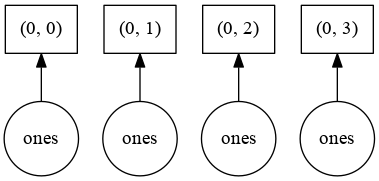

In [9]:
ones.visualize()

In [10]:
sum_of_ones=ones.sum()

In [11]:
sum_of_ones.compute()

4000000.0

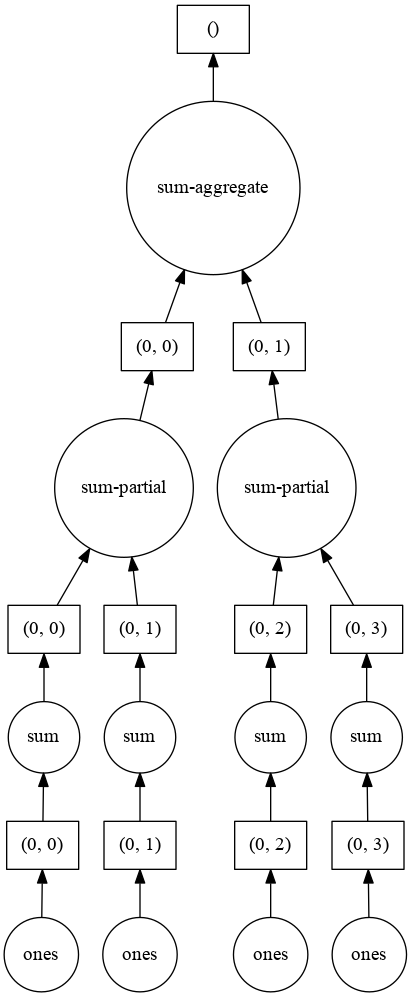

In [12]:
sum_of_ones.visualize()

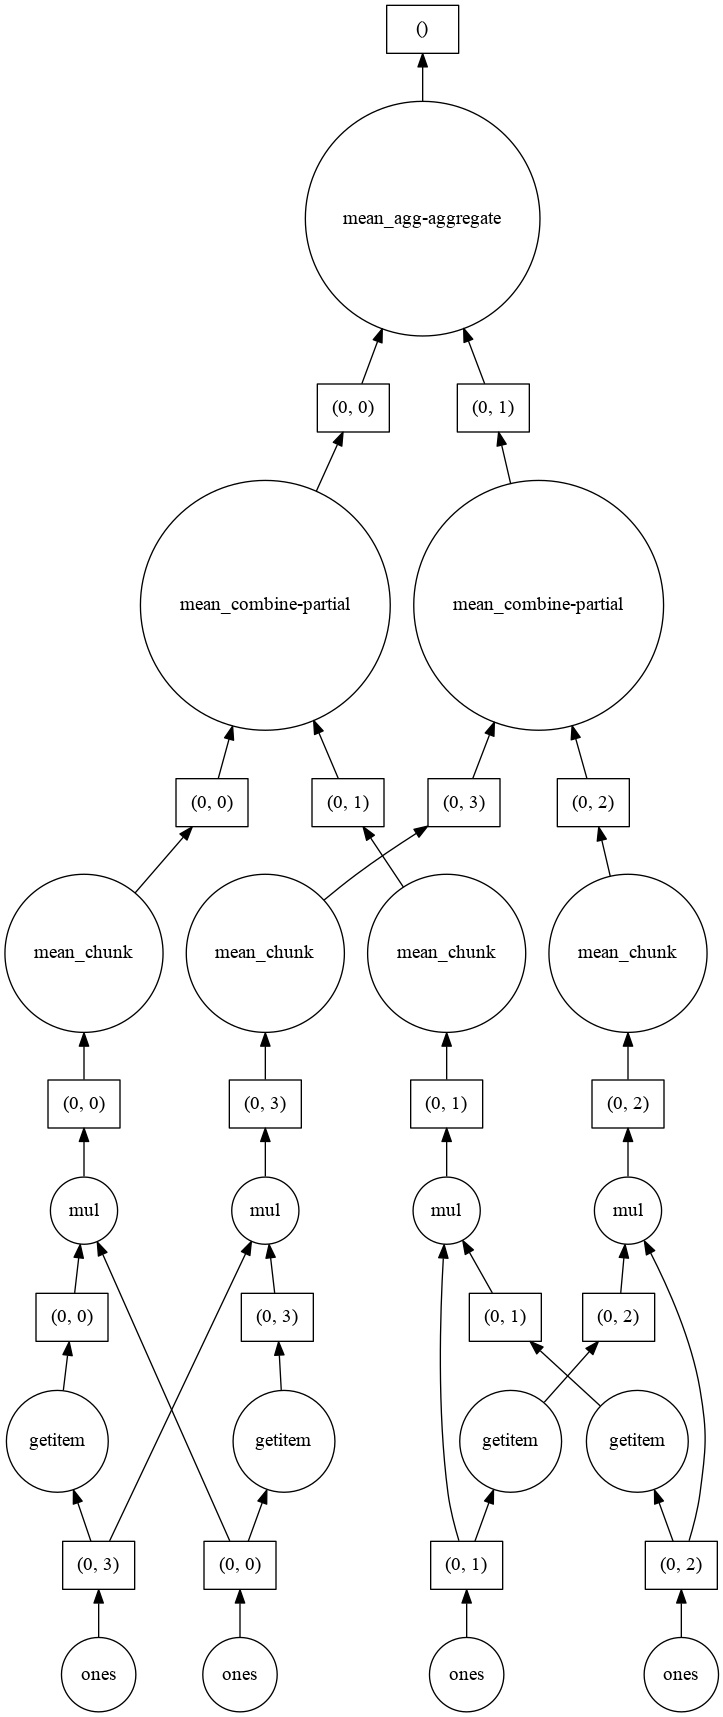

In [13]:
fancy_calculation=(ones*ones[::-1,::-1]).mean()
fancy_calculation.visualize()

In [14]:
fancy_calculation.compute()

1.0

### A Big Calculation

The examples above were toy examples (32Mb).  This data is not big enough to warrant the use of `dask`.  Let's try a much bigger example

In [15]:
bigshape=(200000,4000)
big_ones=da.ones(bigshape,chunks=chunk_shape)
big_ones

dask.array<ones, shape=(200000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [16]:
print(big_ones.nbytes/1e9,"GB")

6.4 GB


DO NOT VISUALIZE THIS!

### Dask has some tools to help us undertand what is happening 

In [17]:
from dask.diagnostics import ProgressBar

big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

with ProgressBar():
    result = big_calc.compute()
result

[########################################] | 100% Completed |  2.1s


1.0

#### All the usual `numpy` (and `xarray`) methods work on `dask` arrays.

In [18]:
big_ones_reduce=(np.cos(big_ones)**2).mean(axis=0)
big_ones_reduce

dask.array<mean_agg-aggregate, shape=(4000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

---------------------------
## Xarray uses dask by default when you use open_mfdataset 
`dask` can be invoked by specifying `chunks` when you open and read your data.

Example: ERA5 daily atmospheric data (multiple presure levels)
File for every day from 1979-2020 


In [19]:
### path='/shared/working/rean/era-interim/daily/data/'
### fname='ei.oper.an.pl.regn128cm.'
path = '/shared/land/ERA5/daily/global_3d/z/'
fname = 'ea_global_an_daily_'


In [20]:
# Create a list of many files to open and read
fnames = path+fname+'*.nc4'
fnames

'/shared/land/ERA5/daily/global_3d/z/ea_global_an_daily_*.nc4'

In [21]:
# Note - you can use a wildcard string in the file name to open multiple files
ds=xr.open_mfdataset(fnames,combine='nested',concat_dim='time')
ds

<xarray.Dataset>
Dimensions:  (plev: 5, rgrid: 542080, time: 15341)
Coordinates:
  * time     (time) float64 1.979e+07 1.979e+07 1.979e+07 ... 2.02e+07 2.02e+07
  * plev     (plev) float64 3e+04 5e+04 7e+04 8.5e+04 1e+05
Dimensions without coordinates: rgrid
Data variables:
    z        (time, plev, rgrid) float32 dask.array<chunksize=(31, 5, 542080), meta=np.ndarray>

### Reduced Gaussian grids are a type of irregular grid
* [How they work](https://confluence.ecmwf.int/display/FCST/Gaussian+grids)
* [The N320 (grid used by ERA5) table by latitude rows](https://confluence.ecmwf.int/display/EMOS/N320)

We need to map each of the grid cells in the reduced Gaussian grid onto their corresponding longitudes and latitudes. 
There is more than one way to do this... 

In [22]:
# One way to reindex the "rgrid" reduced Gaussian grid vector into latitudes and longitudes
rgg_file = '/shared/land/ERA5/N320_reduced_grid.nc4'
rgg = xr.open_dataset(rgg_file)
# rgg is an rgrid-length pair of vectors for the corresponding latitudes and longitudes from the rectangular grid
rgg

<xarray.Dataset>
Dimensions:  (rgrid: 542080)
Dimensions without coordinates: rgrid
Data variables:
    lat      (rgrid) float32 ...
    lon      (rgrid) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Feb 25 14:11:02 2021: cdo -f nc4 -O copy /scratch/rd/na...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [23]:
# Another way to reindex the "rgrid" reduced Gaussian grid vector into latitudes and longitudes
latlon_file = '/shared/land/ERA5/N320_index.nc' 
latlon = xr.open_dataset(latlon_file)
# latlon is 640x1280 lat-lon grid containing the representative "rgrid" value to map to each point on the regular grid. 
latlon

<xarray.Dataset>
Dimensions:  (lat: 640, lon: 1280)
Coordinates:
  * lat      (lat) float64 89.78 89.51 89.23 88.95 ... -89.23 -89.51 -89.78
  * lon      (lon) float64 0.0 0.2812 0.5625 0.8438 ... 358.9 359.2 359.4 359.7
Data variables:
    index    (lat, lon) int32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Feb 25 14:11:02 2021: cdo -f nc4 -O copy /scratch/rd/na...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

### (Re)projecting data

* How would the two different reindexing datasets be applied? 
* What be the result of each?
* Could you produce the same grids of data, and the same maps, from them?

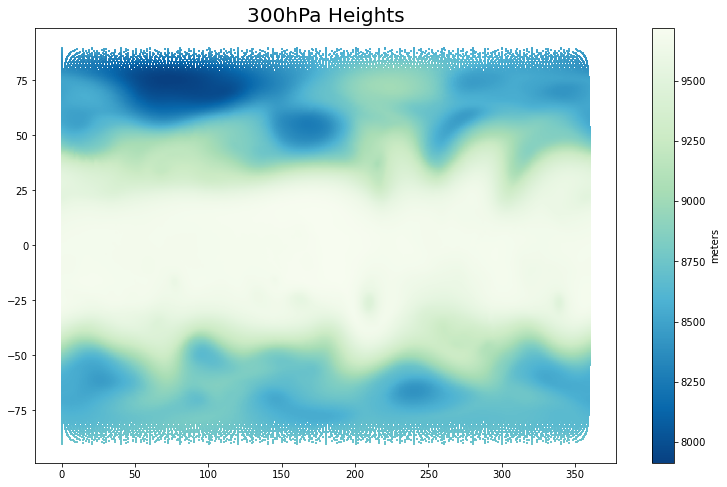

In [24]:
gravity = 9.8 # m/s**2
fig = plt.figure(figsize=(13,8))
plt.scatter(rgg['lon'],rgg['lat'],c=ds["z"][0,0]/gravity,s=1.0,marker='s',cmap="GnBu_r")

plt.title('300hPa Heights',fontsize=20)
plt.colorbar(label='meters')

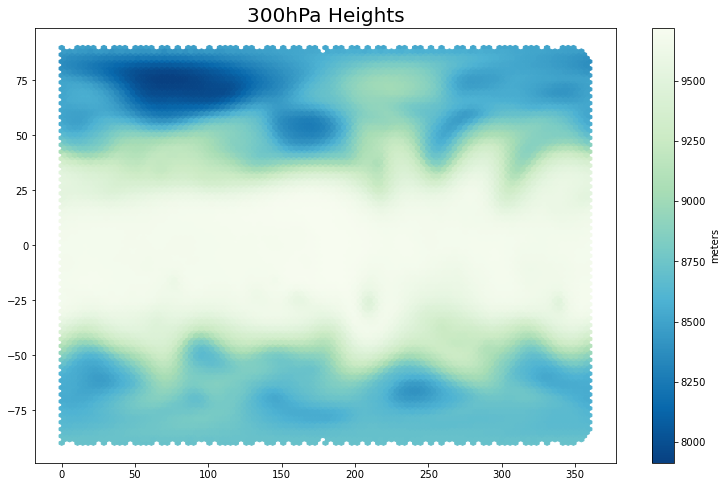

In [25]:
fig = plt.figure(figsize=(13,8))
plt.hexbin(rgg['lon'],rgg['lat'],ds["z"][0,0]/gravity,cmap="GnBu_r")
plt.title('300hPa Heights',fontsize=20)
plt.colorbar(label='meters')

### A function to reconstitute reduced to full Gaussian Grids
`era5_remap` is a Python function that remaps reduced grid data onto the full rectangular (1280x640) Gaussian grid.
* Functions in a `.py` script file can be imported like any other Python pachage or library 

In [26]:
!cp /shared/land/ERA5/era5_remap.py .
from era5_remap import era5_remap
help(era5_remap)

Help on function era5_remap in module era5_remap:

era5_remap(var, type)
    Reconstitutes reduced-grid ERA5 data onto the complete lat-lon grid
    
    Required inputs: 
    `var` is the name of the reduced grid xarray DataArray to be expanded. `var` can be:
        For land-only grids (type=="land")
        • a data variable at one time (a 1-D array along `lgrid`)
        • a time series (`time` and `lgrid` dimensions)
        For global reduced Gaussian grids (type=="rgg")
        • a data variable at one time (a 1-D array along `rgrid`)
        • a time series (`time` and `rgrid` dimensions)
        • a 3-D grid (`rgrid` and vertical `plev` dimensions) 
        • a time series of 3-D grids. 
    `type` is a string that indicates the type of reduced data:
        • "rgg" indicates global data on the reduced Gaussian grid
        • "land" indicates land-only data 
    
    Returns:
        Completely filled lat-lon grid xarray DataArray
     
    ----------
    
    Background
     

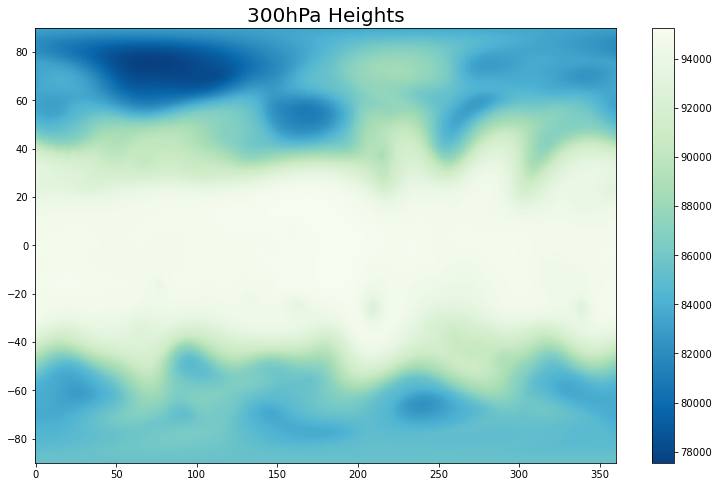

In [27]:
reg_grid = era5_remap(ds["z"][0,0],'rgg')

fig = plt.figure(figsize=(13,8))
plt.pcolormesh(reg_grid.lon,reg_grid.lat,reg_grid,cmap='GnBu_r',shading='nearest')
plt.title('300hPa Heights',fontsize=20)
plt.colorbar()

## How long does it take?

We can use timers to see how long it takes for blocks of code to run. This is a great way to find inefficiencies and understand code performance.

In [28]:
from time import perf_counter

In [29]:
start = perf_counter()
reg_grid = era5_remap(ds["z"][0,0],'rgg') # One level on one day
end_1d = perf_counter()
print("Horizontal field required",end_1d-start,"seconds")

reg_grid = era5_remap(ds["z"][0],'rgg') # All levels on one day
end_2d = perf_counter()
print("Horizontal and vertical field required",end_2d-end_1d,"seconds")

reg_grid = era5_remap(ds["z"][:32,0],'rgg') # All levels for all days in the first month
end_mo = perf_counter()
print("Horizontal and time (one month) field required",end_mo-end_2d,"seconds")


Horizontal field required 0.4405129197984934 seconds
Horizontal and vertical field required 2.05343113001436 seconds
Horizontal and time (one month) field required 14.30188646260649 seconds


### Note that there is not a great deal of scaling here. 
* Processing 31 days takes about 31 times longer than processing one day.
* This is because the function `perf_counter` uses a method called _list comprehension_ to regrid the data.
* _List comprehension_ is much faster than loops, but it is not parallelizable, unlike `dask`.
---------------------

## Here are a few situations when you need to pay attention to the fact that you are using `dask` arrays

__When you get a `chunking` error__

Remember when we did `rolling` and got an error

`daily_climo_smooth=ds_daily_climo.rolling(dayofyear=30,center=True).mean()`

`For window size 30, every chunk should be larger than 15, but the smallest chunk size is 1. Rechunk your array with a larger chunk size or a chunk size that more evenly divides the shape of your array.`

`Dask` was telling us that it couldn't work with the data in its current `chunks`, so we `rechunked` it using:
`ds_daily_climo=ds_daily_climo.chunk({'dayofyear':-1})`

In [30]:
# Let's convert these awkward timestamps into dtype=datetime64 
import pandas as pd
dtobj = pd.to_datetime(list(ds['time'].values), format='%Y%m%d.%f')
ds['time'] = dtobj
ds['time']

<xarray.DataArray 'time' (time: 15341)>
array(['1979-01-01T00:00:00.479166668', '1979-01-02T00:00:00.479166668',
       '1979-01-03T00:00:00.479166668', ..., '2020-12-29T00:00:00.479166668',
       '2020-12-30T00:00:00.479166668', '2020-12-31T00:00:00.479166668'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T00:00:00.479166668 ... 2020-12-...

In [31]:
# Now we can use our .groupby() method to parse through the time dimension
start = perf_counter()
z_climo_jan = ds['z'].groupby('time.month')[1].mean(dim='time')
t1 = perf_counter()
print(t1-start,"seconds")
z_climo_jan.load()
t2 = perf_counter()
print(t2-t1,"seconds")


0.02137636113911867 seconds
94.57369162980467 seconds


Now we can clearly see that our big calculation didn't actually happen at the line where we assigned `z_climo_jan`.

`dask` does not perform actual calculations or even load the data from a file into memory _until it absolutely must_ (e.g., to plot a result).
The `.load()` method forces `dask` to read the data from the file on disk into memory, much as `.compute()` forces `dask` to perform a calculation.

#### When would you want to force `dask` to be _eager_ rather than _lazy_?

* When you want to use computations over and over
    * Example: If you calculate anomalies for a really large dataset and then you want to use the anomalies for the rest of the program without asking `dask` to recompute them each time.


* When you have a performance issue
    * If it is taking a long time to do the calculations, you can tell `dask` to go ahead and `load` the data ahead of time, if you have enough memory, or go ahead and `compute` the computations up to this point.  


See how long it is taking with the progress bar...

[########################################] | 100% Completed | 21.7s


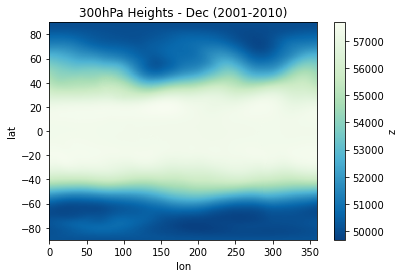

In [33]:
z_decade_climo_jul = ds["z"].sel(plev=50000.,time=slice("2001-01-01", "2010-12-31")).groupby('time.month')[12].mean(dim='time')

with ProgressBar():
    era5_remap(z_decade_climo_jul,'rgg').plot(cmap='GnBu_r') ; plt.title('300hPa Heights - Dec (2001-2010)')

In [34]:
# It's not the remapping or the plotting that takes all the time - it is crunching through the calculation across all that data on disk.
with ProgressBar():
    ds_load=z_decade_climo_jul.load()

[########################################] | 100% Completed | 21.8s


Text(0.5, 1.0, '300hPa Heights - Dec (2001-2010)')

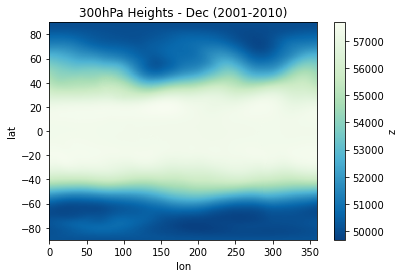

In [35]:
era5_remap(ds_load,'rgg').plot(cmap='GnBu_r')
plt.title('300hPa Heights - Dec (2001-2010)')